In [47]:
import numpy as np
from numpy.linalg import det, inv
import matplotlib.pyplot as plt
%matplotlib inline

In [53]:
def multivar_gauss(x,u,sigma):
    
    x=np.array(x)
    u=np.array(u)
    sigma=np.array(sigma)
    
    assert det(sigma)!=0, "Covariance matrix has zero determinant."
    
    n=x.size
    
    return  (1/ (2 * np.pi**(n/2) * det(sigma)**(1/2))) * np.exp((-1/2) * (x-u).T @ inv(sigma) @ (x-u))

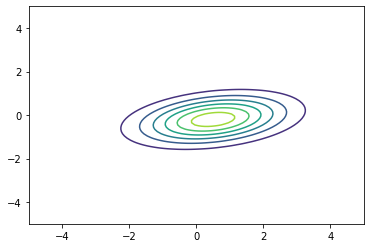

In [86]:
x=np.linspace(-5,5,100)
y=np.linspace(-5,5,100)
xy=np.zeros((100,100,2))
vals=np.zeros((100,100))
for i,d0 in enumerate(x):
    for j,d1 in enumerate(y):
        vals[i,j]=multivar_gauss([d0,d1],[0.5, -0.2], [[2.0, 0.3], [0.3, 0.5]])

plt.contour(x, y, vals.T)

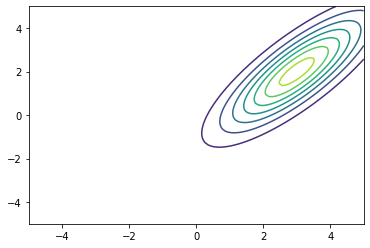

In [95]:
x=np.linspace(-5,5,100)
y=np.linspace(-5,5,100)
xy=np.zeros((100,100,2))
vals=np.zeros((100,100))
for i,d0 in enumerate(x):
    for j,d1 in enumerate(y):
        vals[i,j]=multivar_gauss([d0,d1],[3, 2], [[2.0, 2], [2, 3]])

plt.contour(x, y, vals.T)

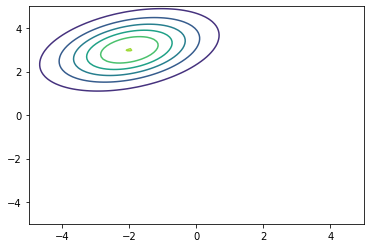

In [99]:
x=np.linspace(-5,5,100)
y=np.linspace(-5,5,100)
xy=np.zeros((100,100,2))
vals=np.zeros((100,100))
for i,d0 in enumerate(x):
    for j,d1 in enumerate(y):
        vals[i,j]=multivar_gauss([d0,d1],[-2,3], [[2.0, 0.5], [0.5, 1]])

plt.contour(x, y, vals.T)

In [102]:
u1,u2,u3=([0.5, -0.2],[3, 2],[-2,3])
s1,s2,s3=([[2.0, 0.3], [0.3, 0.5]], [[2.0, 2], [2, 3]], [[2.0, 0.5], [0.5, 1]])

In [569]:
sample1=np.random.multivariate_normal(u1,s1,50000)
sample2=np.random.multivariate_normal(u2,s2,80000)
sample3=np.random.multivariate_normal(u3,s3,70000)

In [570]:
data=np.concatenate((sample1,sample2,sample3))

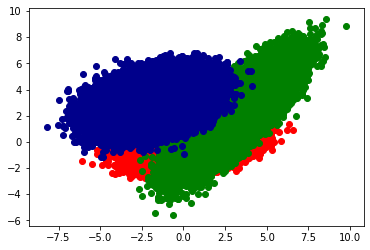

In [571]:
plt.scatter(sample1[:,0],sample1[:,1],color='red')
plt.scatter(sample2[:,0],sample2[:,1],color='green')
plt.scatter(sample3[:,0],sample3[:,1],color='darkblue')

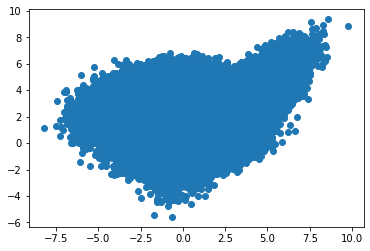

In [572]:
plt.scatter(data[:,0],data[:,1])

In [573]:
X=data

In [539]:
def covariance(X):
    X_n = X-np.mean(X,0)
    return (X_n.T @ X_n)/X.shape[0]

In [581]:
def random_initialize(X, k, random_state=None):
    
    m, n = X.shape
    r = np.random.RandomState(random_state)
    indices=r.choice(m, (k, 3))
    
    means = np.array([X[i].mean(axis=0) for i in indices])
    sigmas = np.array([covariance(X[i]) for i in indices])
    
    return means, sigmas
    

In [574]:
def random_initialize2(X, k, random_state=23):
    
    m, n = X.shape
    r = np.random.RandomState(random_state)
    indices=r.choice(m, k)
    
    means = np.array([X[i] for i in indices])
    sigmas = np.array([covariance(X) for i in range(k)])
    
    return means, sigmas

In [583]:
def gaussianMM(X, k, epochs):
    
    X=np.array(X)
    m, n = X.shape
    
    means, sigmas = random_initialize(X, k)
    pis=[1/k for i in range(k)]
    
    resp = np.zeros((m, k))
    max_likelihood=np.array([])
    
    for c in range(k):
            
        resp[:, c] = np.array([pis[c] * multivar_gauss(i, means[c], sigmas[c]) for i in X])
            
    resp_sum = resp.sum(axis=1)
    max_likelihood=np.append(max_likelihood,np.log(resp_sum).sum())
    resp_sum = resp_sum.reshape(-1,1)
    resp = resp / resp_sum
    
    for ep in range(epochs):
        
        mcs = resp.sum(axis=0)
        pis = mcs / mcs.sum()
        means = [(resp[:,c].reshape(-1,1) * X).sum(axis=0) / mcs[c] for c in range(k)]
        sigmas = [(X.T @ (resp[:,c].reshape(-1,1) * X)) / mcs[c] for c in range(k)]
        
        for c in range(k):
            
            resp[:, c] = np.array([pis[c] * multivar_gauss(i, means[c], sigmas[c]) for i in X])
            
        resp_sum = resp.sum(axis=1)
        max_likelihood=np.append(max_likelihood,np.log(resp_sum).sum())
        resp_sum = resp_sum.reshape(-1,1)
        resp = resp / resp_sum
        
        
    return resp, max_likelihood, means, sigmas ,pis
    

In [514]:
ps

array([0.45614805, 0.31181444, 0.23203751])

In [584]:
rs, mxl, us, sigs, ps = gaussianMM(X, 3, 50)

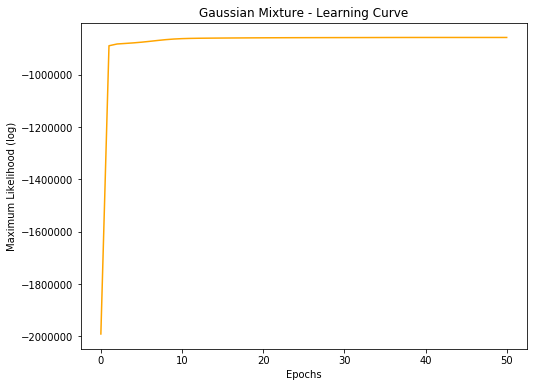

In [585]:
plt.figure(figsize=(8,6))
plt.plot(np.arange(mxl.size),mxl, color='orange')
plt.title("Gaussian Mixture - Learning Curve")
plt.xlabel('Epochs')
plt.ylabel('Maximum Likelihood (log)')
plt.show()

In [586]:
pred=rs.argmax(axis=1)
pred

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

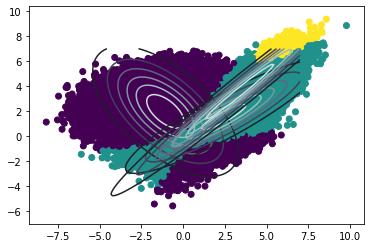

In [587]:
x=np.linspace(-7,7,100)
y=np.linspace(-7,7,100)
z0=[[multivar_gauss([i,j],us[0], sigs[0]) for i in x] for j in y]
z1=[[multivar_gauss([i,j],us[1], sigs[1]) for i in x] for j in y]
z2=[[multivar_gauss([i,j],us[2], sigs[2]) for i in x] for j in y]

plt.contour(x,y, z0, cmap='bone')
plt.contour(x,y, z1,cmap='bone')
plt.contour(x,y, z2,cmap='bone')

colormap= np.array(['r','b','g', 'orange'])
plt.scatter(X[:,0],X[:,1], c=pred)



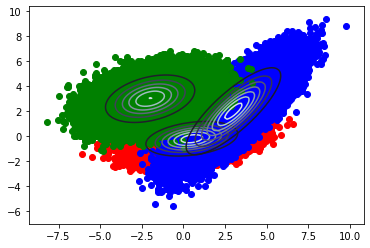

In [588]:
u1,u2,u3=([0.5, -0.2],[3, 2],[-2,3])
s1,s2,s3=([[2.0, 0.3], [0.3, 0.5]], [[2.0, 2], [2, 3]], [[2.0, 0.5], [0.5, 1]])

x=np.linspace(-7,7,100)
y=np.linspace(-7,7,100)

z0=[[multivar_gauss([i,j],u1, s1) for i in x] for j in y]
z1=[[multivar_gauss([i,j],u2, s2) for i in x] for j in y]
z2=[[multivar_gauss([i,j],u3, s3) for i in x] for j in y]

plt.contour(x,y, z0, cmap='bone')
plt.contour(x,y, z1,cmap='bone')
plt.contour(x,y, z2,cmap='bone')

plt.scatter(sample1[:,0],sample1[:,1],color='r')
plt.scatter(sample2[:,0],sample2[:,1],color='b')
plt.scatter(sample3[:,0],sample3[:,1],color='g')